# Week 5: GridSearch on all Response Vars

Summary of this notebook:
- Ran a grid search evaluating 4 kernels and 4 likelihoods for each response variable. Also compared VGP vs GPR for all gaussian likelihoods.
- Found that for response var, a gaussian likelihood, GPR model, and matern 52 kernel result in the best performance.
- Plots for best results compared to original study results at the bottom of the notebook.
- Matern52 kernel led to significant improvements for maxIncidence, but similar results for epidemicSize and logDuration.

### Setup

In [2]:
# import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gpflow
import tensorflow as tf
import itertools

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
import os
os.getcwd()

'/Users/liviafingerson/Desktop/IEMS399/Code'

In [4]:
train_path = "/Users/liviafingerson/Desktop/IEMS399/Dengue/Data/Simulation/Duration/DD-AML-train-LHS-5000-condSim-logDuration.txt"
test_path = "/Users/liviafingerson/Desktop/IEMS399/Dengue/Data/Simulation/Duration/DD-AML-test-LHS-10000-condSim-logDuration.txt"

# Grid Search for maxIncidence, epidemicSize, log(Duration)

### Helper Functions

#### Reset Data
- Input: numtrain, numtest, res_var, df = False
- Output: Xtrain, Xtest, Ytrain, Ytest

In [5]:
# define function to reload the data and reset, so that I can call it each time I model.

def reset_data(numtrain, numtest, res_var, df = False): 

    # read data
    train_set = pd.read_csv(train_path, sep = "\t")
    test_set = pd.read_csv(test_path, sep = "\t")

    # take log of duration
    train_set['log duration'] = np.log(train_set['duration'])  
    test_set['log duration'] = np.log(test_set['duration'])

    # drop unnecessary columns
    drop_cols = [ 'simRound', 'simID']

    possible_response_vars = ['log duration', 'duration', 'epidemicSize', 'maxIncidence','sd_maxIncidence', 'sd_epidemicSize', 'sd_duration']

    for item in possible_response_vars:
        if item != res_var:
           drop_cols.append(item)

    train_set = train_set.drop(drop_cols, axis=1)
    test_set = test_set.drop(drop_cols, axis=1)

    # size check
    numtrain = min(numtrain, len(train_set))
    numtest = min(numtest, len(test_set))

    # select random n points
    train_subset = train_set.sample(n=numtrain, random_state=22)
    Xtrain_df = train_subset.drop(res_var, axis=1)
    Xtrain = Xtrain_df.to_numpy()
    Ytrain_df = train_subset[res_var]
    Ytrain = Ytrain_df.to_numpy().reshape(-1, 1)

    test_subset = test_set.sample(n=numtest, random_state=22)
    Xtest_df = test_subset.drop(res_var, axis=1)
    Xtest = Xtest_df.to_numpy()
    Ytest_df = test_subset[res_var]
    Ytest = Ytest_df.to_numpy().reshape(-1, 1)

    if df:
        return Xtrain_df, Xtest_df, Ytrain_df, Ytest_df
    else:
        return Xtrain, Xtest, Ytrain, Ytest

#### Model Functions

- Input: res_var, kernelchoice, meanfunctionchoice, likelihoodchoice, ntrain = None, ntest = None
- Output: mod, Xtest, Ytest

In [6]:
def gpr(res_var, kernelchoice, meanfunctionchoice, likelihoodchoice, ntrain = None, ntest = None):

    if ntrain == None:
        ntrain = 800
    if ntest == None:
        ntest = 200

    # reset data
    Xtrain, Xtest, Ytrain, Ytest = reset_data(ntrain, ntest, res_var) # 80 20 for now

    # create model
    mod = gpflow.models.GPR(data=(Xtrain, Ytrain), kernel=kernelchoice, mean_function=meanfunctionchoice, likelihood = likelihoodchoice )

    # train model
    opt = gpflow.optimizers.Scipy()
    opt.minimize(mod.training_loss, mod.trainable_variables)

    return mod, Xtest, Ytest

In [7]:
def vgp(res_var, kernelchoice, meanfunctionchoice, likelihoodchoice, ntrain = None, ntest = None):

    if ntrain == None:
        ntrain = 800
    if ntest == None:
        ntest = 200

    # reset data
    Xtrain, Xtest, Ytrain, Ytest = reset_data(ntrain, ntest, res_var) # 80 20 for now

    # create model
    #mod = gpflow.models.GPR(data=(Xtrain, Ytrain), kernel=gpflow.kernels.Matern12(),) 
    mod = gpflow.models.VGP(data=(Xtrain, Ytrain), 
                            kernel=kernelchoice, 
                            mean_function=meanfunctionchoice, 
                            likelihood = likelihoodchoice)

    # train model
    opt = gpflow.optimizers.Scipy()
    opt.minimize(mod.training_loss, mod.trainable_variables)

    return mod, Xtest, Ytest

#### Plot Function
- Input: model, res_var, Xtest, Ytest
- Output: None

In [8]:
def plot_gp(model, res_var, Xtest, Ytest):
    
    mod = model

    # make predictions
    f_mean, _ = mod.predict_f(Xtest) # returns mean and variance (uncertainty) of function f (no noise)
    y_mean, y_var = mod.predict_y(Xtest)

    ## 95% confidence intervals for y
    y_lower = y_mean - 1.96 * np.sqrt(y_var)
    y_upper = y_mean + 1.96 * np.sqrt(y_var)

    #print("MSE ({res_var}):", mean_squared_error(Ytest, y_mean))
    print(f"RMSE:", mean_squared_error(Ytest, y_mean, squared=False))

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))

    error = y_mean - Ytest

    axes[0].scatter(y_mean, error)
    axes[0].set_title(f"GP: Fitted Values vs Prediction Error ({res_var})")
    axes[0].set_xlabel("Fitted Values")
    axes[0].set_ylabel(f"Prediction Error ({res_var})")
    axes[0].axhline(y=0, color='red', linestyle='--')

    axes[1].scatter(y_mean, Ytest)
    axes[1].set_title(f"GP: Fitted Values vs Actual Values ({res_var})")
    axes[1].set_xlabel("Fitted Values")
    axes[1].set_ylabel(f"Actual Values ({res_var})")

    # to add a y = x line
    x_min, x_max = axes[1].get_xlim()
    y_min, y_max = axes[1].get_ylim()
    range_max = max(x_max, y_max)
    range_min = min(x_min, y_min)
    plt.plot([range_min, range_max], [range_min, range_max], 'r--', label='y=x')  # 'r--' specifies a red dashed line
    
    plt.tight_layout()
    plt.show()

#### Statistic Recording Function
- Input: df, res_var, model, Xtest, Ytest, kernelchoice, meanfunctionchoice, likelihoodchoice, ntrain=None, ntest=None
- Output: df

In [9]:
def add_stats(df, res_var, model, Xtest, Ytest, kernelchoice, meanfunctionchoice, likelihoodchoice, ntrain=None, ntest=None):

    if ntrain == None:
        ntrain = 800
    if ntest == None:
        ntest = 200

    mod = model

    # make predictions
    f_mean, _ = mod.predict_f(Xtest) # returns mean and variance (uncertainty) of function f (no noise)
    y_mean, y_var = mod.predict_y(Xtest)

    mse = mean_squared_error(Ytest, y_mean)
    rmse = mean_squared_error(Ytest, y_mean, squared=False)
    nrmse = rmse / np.mean(Ytest)
    
    new_row = pd.DataFrame([{
        'Response Variable': str(res_var), 
        'Type': str(mod.name),
        'Kernel': str(kernelchoice),
        'Likelihood': str(likelihoodchoice),
        'Mean Function': str(meanfunctionchoice),
        'RMSE': float(rmse), 
        'Normalized RMSE': float(nrmse),
        'N train': int(ntrain),
        'N test': int(ntest),
    }])
    
    df = pd.concat([df, new_row], ignore_index=True)

    return df

#### Run and Log Function
- Input: results_df, res_var, model_func, kernelchoice, meanfunctionchoice=None, likelihoodchoice=None, plot=True, log=True
- Output: results_df

In [10]:
def run_and_log_gp(
    results_df,
    res_var,
    model_func,
    kernelchoice,
    meanfunctionchoice=None,
    likelihoodchoice=None,
    plot=True,
    log=True,
):

    # Get the model, test data
    model, Xtest, Ytest = model_func(
        res_var = res_var,
        kernelchoice=kernelchoice,
        meanfunctionchoice=meanfunctionchoice,
        likelihoodchoice=likelihoodchoice
    )

    # Plot
    if plot:
        plot_gp(model, res_var, Xtest, Ytest)

    if log:
        # Add stats to results dataframe
        updated_results = add_stats(
            df=results_df,
            res_var = res_var,
            model=model,
            Xtest=Xtest,
            Ytest=Ytest,
            kernelchoice=kernelchoice.__class__.__name__,
            meanfunctionchoice=("Constant" if meanfunctionchoice is None else meanfunctionchoice.__class__.__name__),
            likelihoodchoice=("Gaussian" if likelihoodchoice is None else likelihoodchoice.__class__.__name__)
        )

        return updated_results
    
    else:
        return results_df

### Grid Search

In [202]:
# function to perform grid search

import warnings

def grid_check(df, res_var, kernels, likelihoods):

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

    for kernel, likelihood in itertools.product(kernels, likelihoods):
        try:
            print(f"Running model with: {kernel.__class__.__name__}, {likelihood.__class__.__name__}")

            if isinstance(likelihood, gpflow.likelihoods.Gaussian): # this line is not functioning
                print("GPR!")
                df = run_and_log_gp(df, res_var, gpr, kernel, likelihoodchoice=likelihood, plot=False)
            
            print("VGP!")
            df = run_and_log_gp(df, res_var, vgp, kernel, likelihoodchoice=likelihood, plot=False)
                

        except Exception as e:
            print(f"Failed for combo {kernel}, {likelihood}, {e}")
            continue

    df = df.sort_values('RMSE')
    return df


### Using Grid Search

In [204]:
# initialize empty dataframe

resvar_grid = pd.DataFrame({
    'Response Variable': pd.Series(dtype='str'),
    'Type': pd.Series(dtype='str'),
    'Kernel': pd.Series(dtype='str'),
    'Likelihood': pd.Series(dtype='str'),
    'Mean Function': pd.Series(dtype='str'),
    'RMSE': pd.Series(dtype='float'),
    'Normalized RMSE': pd.Series(dtype='float'),
    'N train': pd.Series(dtype='int'),
    'N test': pd.Series(dtype='int')
})

In [205]:
# model components
kernel_list = [
    gpflow.kernels.SquaredExponential(),
    gpflow.kernels.Matern12(),
    gpflow.kernels.Matern32(),
    gpflow.kernels.Matern52(),
]

likelihood_list = [
    gpflow.likelihoods.Poisson(),
    gpflow.likelihoods.Gamma(),
    gpflow.likelihoods.Gaussian(),
    gpflow.likelihoods.Exponential()
]

In [206]:
resvar_grid = grid_check(resvar_grid, res_var = 'maxIncidence', kernels=kernel_list, likelihoods=likelihood_list)

Running model with: SquaredExponential, Poisson
VGP!
Running model with: SquaredExponential, Gamma
VGP!
Running model with: SquaredExponential, Gaussian
GPR!
VGP!
Running model with: SquaredExponential, Exponential
VGP!
Running model with: Matern12, Poisson
VGP!
Running model with: Matern12, Gamma
VGP!
Running model with: Matern12, Gaussian
GPR!
VGP!
Running model with: Matern12, Exponential
VGP!
Running model with: Matern32, Poisson
VGP!
Running model with: Matern32, Gamma
VGP!
Running model with: Matern32, Gaussian
GPR!
VGP!
Running model with: Matern32, Exponential
VGP!
Running model with: Matern52, Poisson
VGP!
Running model with: Matern52, Gamma
VGP!
Running model with: Matern52, Gaussian
GPR!
VGP!
Running model with: Matern52, Exponential
VGP!
Failed for combo <gpflow.kernels.stationaries.Matern52 object at 0x3b2ec5d80>, <gpflow.likelihoods.scalar_continuous.Exponential object at 0x3b583e230>, Input contains infinity or a value too large for dtype('float64').


In [209]:
resvar_grid = grid_check(resvar_grid, res_var = 'epidemicSize', kernels=kernel_list, likelihoods=likelihood_list)

Running model with: SquaredExponential, Poisson
VGP!
Failed for combo <gpflow.kernels.stationaries.SquaredExponential object at 0x3daae1330>, <gpflow.likelihoods.scalar_discrete.Poisson object at 0x3daae14b0>, Input contains infinity or a value too large for dtype('float64').
Running model with: SquaredExponential, Gamma
VGP!
Failed for combo <gpflow.kernels.stationaries.SquaredExponential object at 0x3daae1330>, <gpflow.likelihoods.scalar_continuous.Gamma object at 0x3daae1a20>, Input contains infinity or a value too large for dtype('float64').
Running model with: SquaredExponential, Gaussian
GPR!
VGP!
Running model with: SquaredExponential, Exponential
VGP!
Failed for combo <gpflow.kernels.stationaries.SquaredExponential object at 0x3daae1330>, <gpflow.likelihoods.scalar_continuous.Exponential object at 0x3b583e230>, Input contains infinity or a value too large for dtype('float64').
Running model with: Matern12, Poisson
VGP!
Running model with: Matern12, Gamma
VGP!
Running model with

In [210]:
resvar_grid = grid_check(resvar_grid, res_var = 'log duration', kernels=kernel_list, likelihoods=likelihood_list)

Running model with: SquaredExponential, Poisson
VGP!
Failed for combo <gpflow.kernels.stationaries.SquaredExponential object at 0x3daae1330>, <gpflow.likelihoods.scalar_discrete.Poisson object at 0x3daae14b0>, Input contains infinity or a value too large for dtype('float64').
Running model with: SquaredExponential, Gamma
VGP!
Failed for combo <gpflow.kernels.stationaries.SquaredExponential object at 0x3daae1330>, <gpflow.likelihoods.scalar_continuous.Gamma object at 0x3daae1a20>, Input contains infinity or a value too large for dtype('float64').
Running model with: SquaredExponential, Gaussian
GPR!
VGP!
Running model with: SquaredExponential, Exponential
VGP!
Failed for combo <gpflow.kernels.stationaries.SquaredExponential object at 0x3daae1330>, <gpflow.likelihoods.scalar_continuous.Exponential object at 0x3b583e230>, Input contains infinity or a value too large for dtype('float64').
Running model with: Matern12, Poisson
VGP!
Running model with: Matern12, Gamma
VGP!
Running model with

### Grid Search Results

In [212]:
resvar_grid[resvar_grid['Response Variable'] == 'maxIncidence']

,Response Variable,Type,Kernel,Likelihood,Mean Function,RMSE,Normalized RMSE,N train,N test
0,maxIncidence,gpr,Matern52,Gaussian,Constant,1.546616e-01,2.657316e-01,800,200
1,maxIncidence,vgp,SquaredExponential,Gaussian,Constant,1.582822e-01,2.719523e-01,800,200
2,maxIncidence,vgp,Matern52,Gaussian,Constant,1.759582e-01,3.023223e-01,800,200
14,maxIncidence,gpr,SquaredExponential,Gaussian,Constant,2.164346e-01,3.718668e-01,800,200
15,maxIncidence,gpr,Matern32,Gaussian,Constant,2.298679e-01,3.949472e-01,800,200
16,maxIncidence,vgp,Matern32,Gaussian,Constant,2.299147e-01,3.950276e-01,800,200
17,maxIncidence,gpr,Matern12,Gaussian,Constant,2.355981e-01,4.047925e-01,800,200
18,maxIncidence,vgp,Matern12,Gaussian,Constant,2.356031e-01,4.048011e-01,800,200
19,maxIncidence,vgp,SquaredExponential,Gamma,Constant,2.356058e-01,4.048057e-01,800,200
20,maxIncidence,vgp,Matern32,Gamma,Constant,2.359050e-01,4.053198e-01,800,200


In [213]:
resvar_grid[resvar_grid['Response Variable'] == 'epidemicSize']

,Response Variable,Type,Kernel,Likelihood,Mean Function,RMSE,Normalized RMSE,N train,N test
3,epidemicSize,gpr,SquaredExponential,Gaussian,Constant,1.869778e-01,2.067555e-01,800,200
4,epidemicSize,gpr,Matern52,Gaussian,Constant,1.871148e-01,2.069069e-01,800,200
5,epidemicSize,vgp,Matern52,Gaussian,Constant,1.897817e-01,2.098559e-01,800,200
6,epidemicSize,vgp,SquaredExponential,Gaussian,Constant,1.916642e-01,2.119375e-01,800,200
7,epidemicSize,gpr,Matern32,Gaussian,Constant,2.015036e-01,2.228177e-01,800,200
8,epidemicSize,vgp,Matern32,Gaussian,Constant,2.015056e-01,2.228199e-01,800,200
9,epidemicSize,gpr,Matern12,Gaussian,Constant,2.046723e-01,2.263216e-01,800,200
10,epidemicSize,vgp,Matern12,Gaussian,Constant,2.047872e-01,2.264486e-01,800,200
11,epidemicSize,vgp,Matern32,Gamma,Constant,2.060482e-01,2.278431e-01,800,200
12,epidemicSize,vgp,Matern32,Poisson,Constant,2.149234e-01,2.376571e-01,800,200


In [214]:
resvar_grid[resvar_grid['Response Variable'] == 'log duration']

,Response Variable,Type,Kernel,Likelihood,Mean Function,RMSE,Normalized RMSE,N train,N test
45,log duration,gpr,Matern52,Gaussian,Constant,8.012820e-02,1.462837e-01,800,200
33,log duration,gpr,SquaredExponential,Gaussian,Constant,8.269673e-02,1.509728e-01,800,200
46,log duration,vgp,Matern52,Gaussian,Constant,9.226844e-02,1.684472e-01,800,200
34,log duration,vgp,SquaredExponential,Gaussian,Constant,9.260993e-02,1.690706e-01,800,200
41,log duration,vgp,Matern32,Gamma,Constant,1.174166e-01,2.143582e-01,800,200
42,log duration,gpr,Matern32,Gaussian,Constant,1.176242e-01,2.147371e-01,800,200
43,log duration,vgp,Matern32,Gaussian,Constant,1.176438e-01,2.147729e-01,800,200
38,log duration,vgp,Matern12,Gaussian,Constant,1.212437e-01,2.213450e-01,800,200
37,log duration,gpr,Matern12,Gaussian,Constant,1.214363e-01,2.216965e-01,800,200
44,log duration,vgp,Matern32,Exponential,Constant,1.231869e-01,2.248925e-01,800,200


### Visualizing Best Results

From the grid search, each response variable seems to perform best with GPR, Matern52 kernel and Gaussian likelihood. (For epidemic size, squared exponential kernel performed about the same according to RSME. I am choosing to model with Matern52.)

#### Max Incidence
Gaussian, Matern 52

In [43]:
# for max incidence: gaussian, matern 52
Xtrain, Xtest, Ytrain, Ytest = reset_data(800, 200, 'maxIncidence')
maxIncMod = gpflow.models.GPR(data=(Xtrain, Ytrain), kernel=gpflow.kernels.Matern52(), likelihood = gpflow.likelihoods.Gaussian())
opt = gpflow.optimizers.Scipy()
opt.minimize(maxIncMod.training_loss, maxIncMod.trainable_variables)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -253.90994116385696
        x: [ 2.471e+02  9.927e+06 -3.935e+00]
      nit: 91
      jac: [ 1.642e-02 -1.831e-07 -7.031e-03]
     nfev: 150
     njev: 150
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

RMSE: 0.15356003895921605


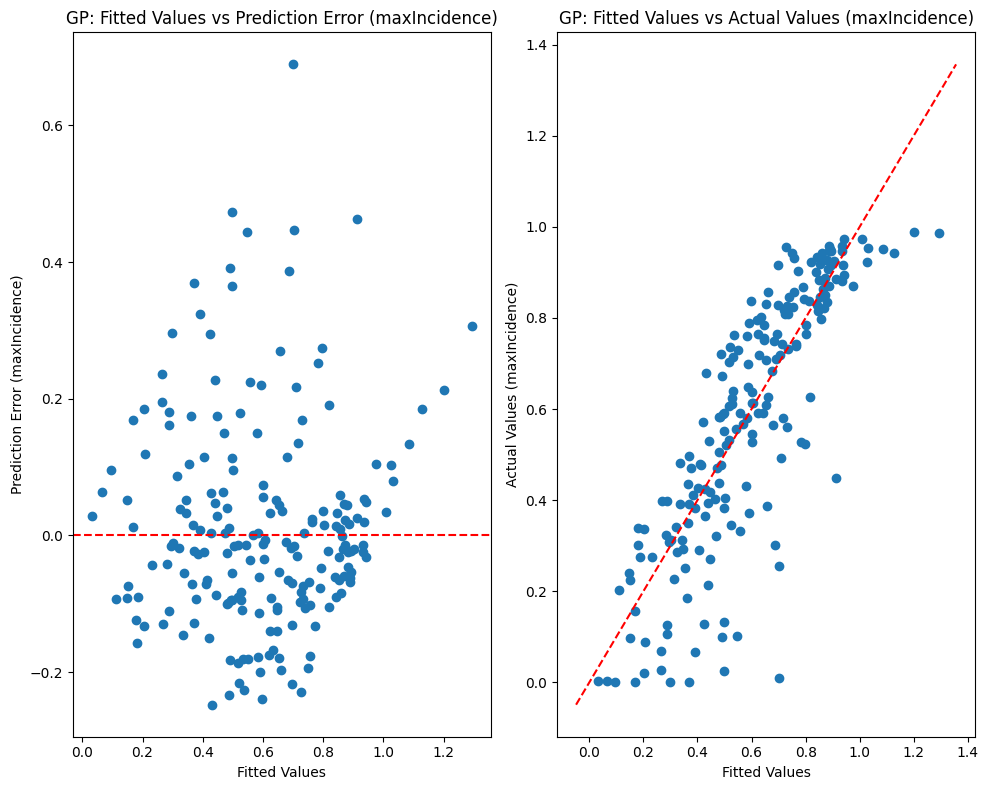

In [44]:
plot_gp(model = maxIncMod, Xtest = Xtest, Ytest = Ytest, res_var = 'maxIncidence')

RMSE: 0.23575701986528497


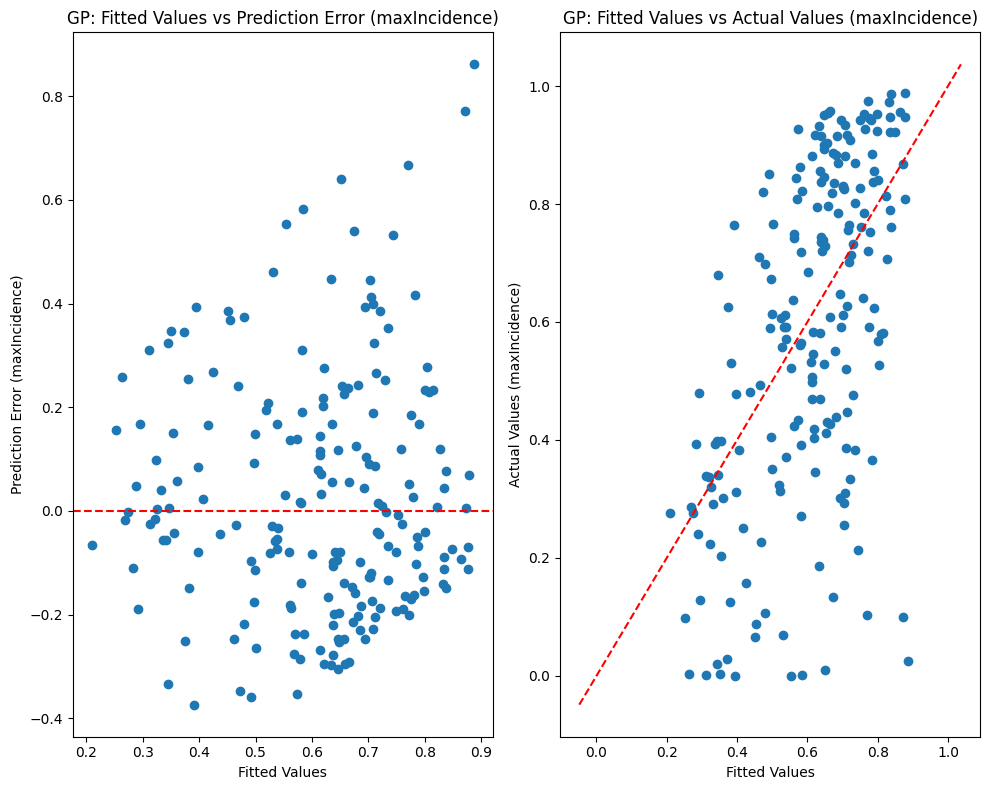

In [45]:
OGmaxIncMod = gpflow.models.GPR(data=(Xtrain, Ytrain), kernel=gpflow.kernels.Matern12(), likelihood = gpflow.likelihoods.Gaussian())
opt = gpflow.optimizers.Scipy()
opt.minimize(OGmaxIncMod.training_loss, OGmaxIncMod.trainable_variables)
plot_gp(model = OGmaxIncMod , Xtest = Xtest, Ytest = Ytest, res_var = 'maxIncidence')

#### Epidemic Size
Gaussian, Matern 52

In [40]:
# for epidemic size: gaussian, matern 52
Xtrain, Xtest, Ytrain, Ytest = reset_data(800, 200, 'epidemicSize')
epSizeMod = gpflow.models.GPR(data=(Xtrain, Ytrain), kernel=gpflow.kernels.Matern52(), likelihood = gpflow.likelihoods.Gaussian())
opt = gpflow.optimizers.Scipy()
opt.minimize(epSizeMod.training_loss, epSizeMod.trainable_variables)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -106.82585934664485
        x: [ 5.959e+01  3.666e+00 -3.126e+00]
      nit: 29
      jac: [-1.816e-09 -7.964e-08  1.953e-06]
     nfev: 36
     njev: 36
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

RMSE: 0.20129227976635028


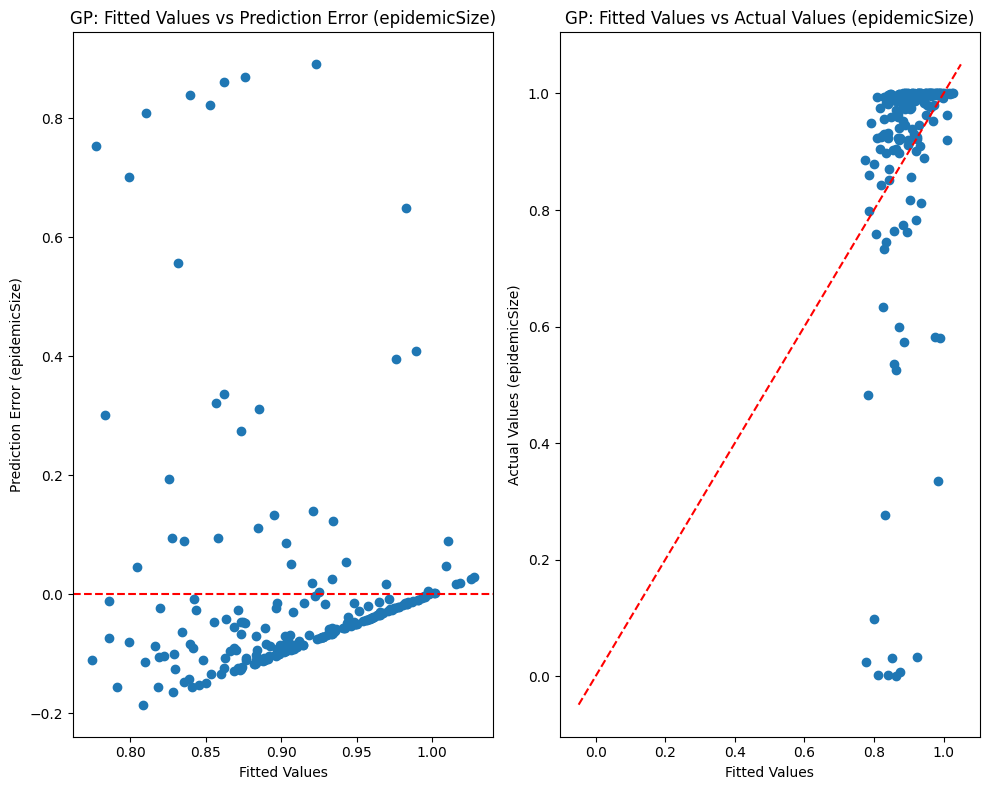

In [41]:
plot_gp(model = epSizeMod, Xtest = Xtest, Ytest = Ytest, res_var = 'epidemicSize')

RMSE: 0.2049732707800361


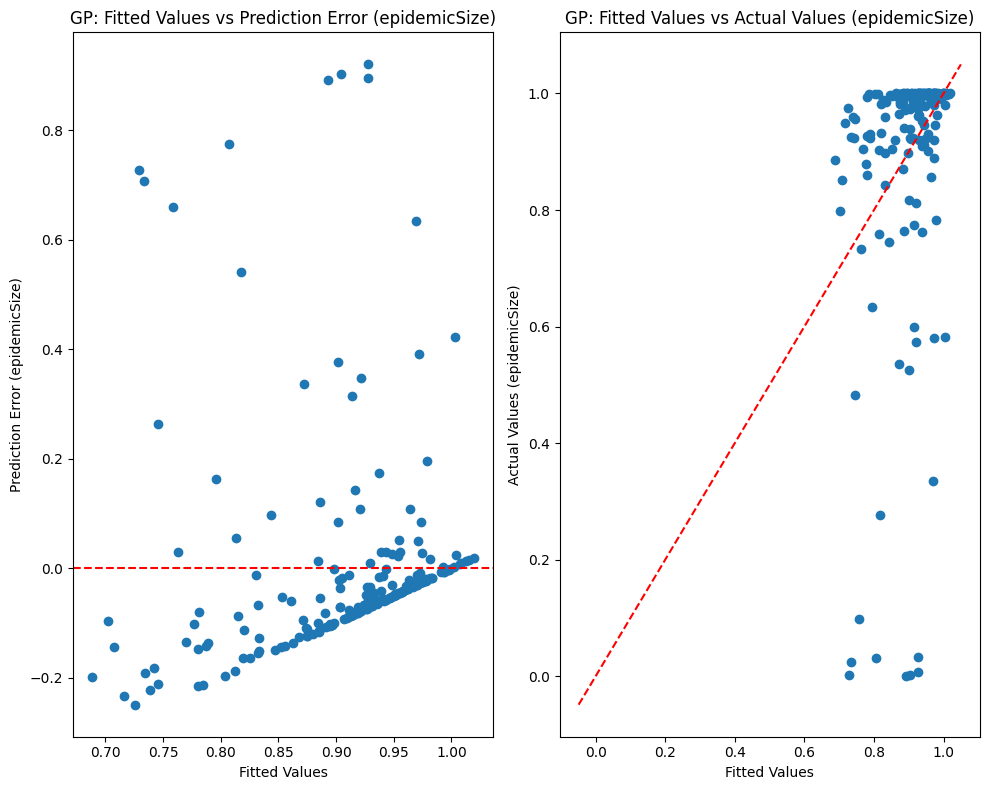

In [42]:
OGepSizeMod = gpflow.models.GPR(data=(Xtrain, Ytrain), kernel=gpflow.kernels.Matern12(), likelihood = gpflow.likelihoods.Gaussian())
opt = gpflow.optimizers.Scipy()
opt.minimize(OGepSizeMod.training_loss, OGepSizeMod.trainable_variables)
plot_gp(model = OGepSizeMod , Xtest = Xtest, Ytest = Ytest, res_var = 'epidemicSize')

#### Log Duration
Gaussian, Matern 52

In [34]:
# for log duration: gaussian, matern 52
Xtrain, Xtest, Ytrain, Ytest = reset_data(800, 200, 'log duration')
logDurMod = gpflow.models.GPR(data=(Xtrain, Ytrain), kernel=gpflow.kernels.Matern52(), likelihood = gpflow.likelihoods.Gaussian())
opt = gpflow.optimizers.Scipy()
opt.minimize(logDurMod.training_loss, logDurMod.trainable_variables)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -529.3042622723497
        x: [ 1.511e+02  2.561e+01 -4.208e+00]
      nit: 31
      jac: [ 8.163e-05 -4.040e-04 -7.176e-02]
     nfev: 38
     njev: 38
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

RMSE: 0.11724376468182675


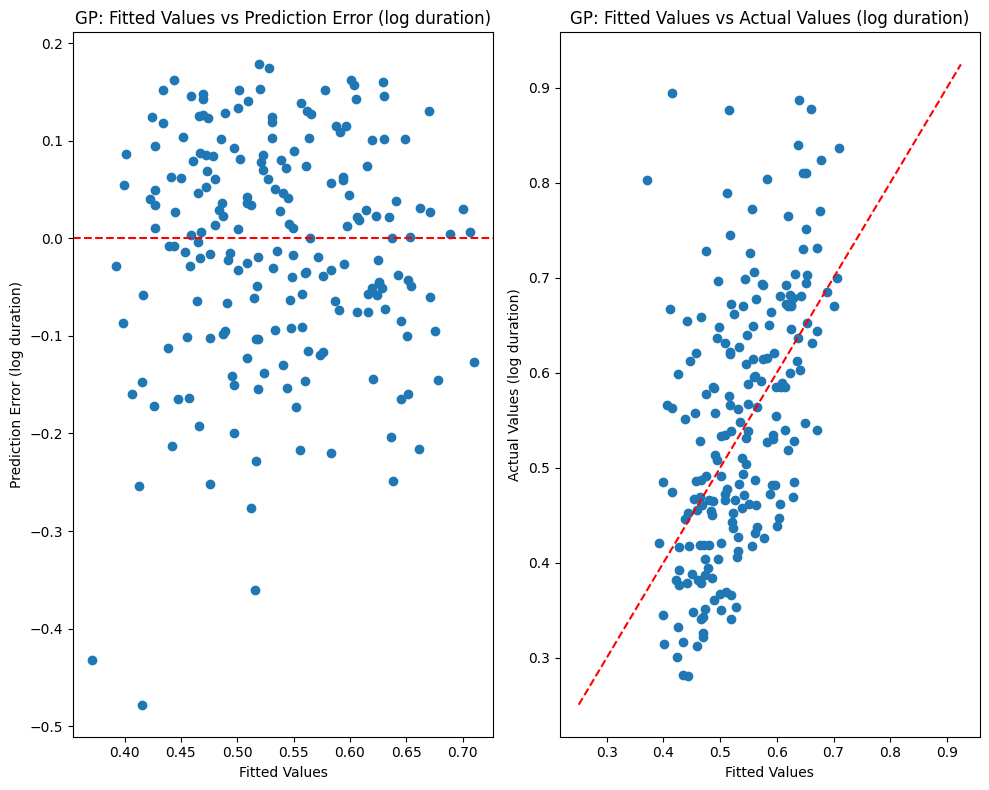

In [35]:
plot_gp(model = logDurMod , Xtest = Xtest, Ytest = Ytest, res_var = 'log duration')

RMSE: 0.11980547443082125


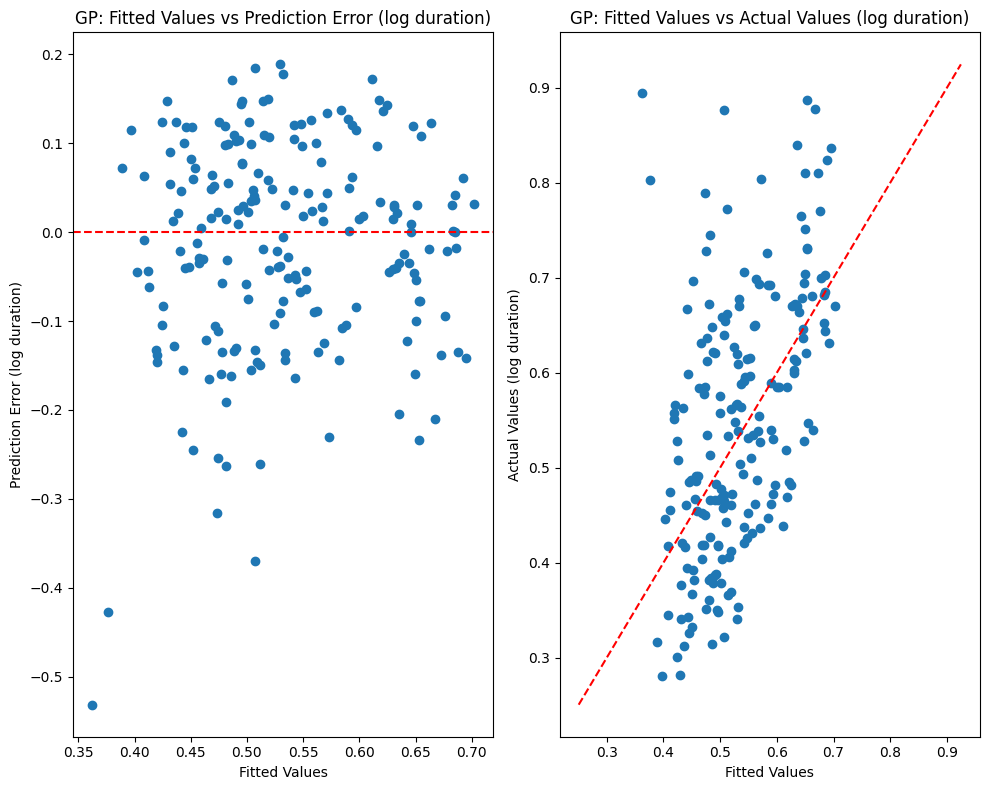

In [36]:
OGlogDurMod = gpflow.models.GPR(data=(Xtrain, Ytrain), kernel=gpflow.kernels.Matern12(), likelihood = gpflow.likelihoods.Gaussian())
opt = gpflow.optimizers.Scipy()
opt.minimize(OGlogDurMod.training_loss, OGlogDurMod.trainable_variables)
plot_gp(model = OGlogDurMod , Xtest = Xtest, Ytest = Ytest, res_var = 'log duration')